## Imports

In [1]:
import pandas as pd
import os
from openpyxl import Workbook
from simplified_scrapy import SimplifiedDoc, utils
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
pd.set_option('display.float_format', '{:.2f}'.format)

## Morningstar dataset conversion to Excel file (.xlsx)

In [2]:
"""
import os
files = []
for i in os.walk('./datasets'):
    files= i[2]
    
print(files)
"""

"\nimport os\nfiles = []\nfor i in os.walk('./datasets'):\n    files= i[2]\n    \nprint(files)\n"

In [3]:
"""
def readFile(filename):
    xml = utils.getFileContent(filename)
    doc = SimplifiedDoc(xml)
    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data
    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name
    return sheetNames,tables,filename.split('/')[2].split('.')[0]

def to_Excel(sheetNames,tables, filename):
    wb = Workbook() # Create Workbook
    for i in range(len(sheetNames)):
        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet
        for row in tables[i]:
            worksheet.append(row)
    print('./datasets_excel/'+ filename + '.xlsx')
    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file
"""

"\ndef readFile(filename):\n    xml = utils.getFileContent(filename)\n    doc = SimplifiedDoc(xml)\n    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data\n    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name\n    return sheetNames,tables,filename.split('/')[2].split('.')[0]\n\ndef to_Excel(sheetNames,tables, filename):\n    wb = Workbook() # Create Workbook\n    for i in range(len(sheetNames)):\n        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet\n        for row in tables[i]:\n            worksheet.append(row)\n    print('./datasets_excel/'+ filename + '.xlsx')\n    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file\n"

In [4]:
"""
for filename in (os.listdir("./datasets")):
        name = filename.split('.')[0]
        print(name)
        
        dst = name + ".xml"
        src ='./datasets/'+ filename
        dst ='./datasets/'+ dst
          
        # rename() function will
        # rename all the files
        os.rename(src, dst)
"""

'\nfor filename in (os.listdir("./datasets")):\n        name = filename.split(\'.\')[0]\n        print(name)\n        \n        dst = name + ".xml"\n        src =\'./datasets/\'+ filename\n        dst =\'./datasets/\'+ dst\n          \n        # rename() function will\n        # rename all the files\n        os.rename(src, dst)\n'

In [5]:
"""
for file in files:
    to_Excel(*readFile("./datasets/" + file))
"""

'\nfor file in files:\n    to_Excel(*readFile("./datasets/" + file))\n'

## Import datasets into Pandas dataframes

In [6]:
files = []
for i in os.walk('./datasets_excel/'):
    files=i[2]

workbooks = {}
for file in files:
    workbooks[file.split('.')[0]] = pd.read_excel('./datasets_excel/' + file, sheet_name=None)

## Cleaning

### Normalising statement items (WIP)

In [7]:
statement_items = defaultdict(set)

for workbook in workbooks:
    for sheet in workbooks[workbook]:
        if sheet != 'Sheet' and 'Item' in workbooks[workbook][sheet]:
            statement_items[sheet].update(workbooks[workbook][sheet]['Item'])

### Restructuring datasets and creating combined HY and FY dataset

In [8]:
workbooks_combined = defaultdict(dict)
workbooks_keys = list(workbooks.keys())

for i in range(len(workbooks)//2):
    for sheet in statement_items:
        workbook_FY = workbooks[workbooks_keys[i*2]] # Reading in the full-yearly statements
        workbook_HY = workbooks[workbooks_keys[i*2 + 1]] # Reading in the half-yearly statements
        new_sheet = _ 
        
        if sheet in workbook_FY:
            sheet_FY = workbook_FY[sheet].drop(['ASX Code', 'Company Name'], axis=1)
            sheet_HY = workbook_HY[sheet].drop(['ASX Code', 'Company Name'], axis=1)

            new_sheet = pd.concat([sheet_FY, sheet_HY], axis=1, join='inner')
            new_sheet = new_sheet.loc[:,~new_sheet.columns.duplicated()] # Drop extra 'item' 
            new_sheet = new_sheet.set_index(['Item'])
            
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_combined[workbooks_keys[i*2].split('_')[0]][sheet] = new_sheet.transpose()    
        else:
            print("Missing tab:", workbooks_keys[i*2], sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis


In [9]:
workbooks_separated = defaultdict(lambda: defaultdict(dict))
workbooks_keys = list(workbooks.keys())

for workbook in workbooks:
    for sheet in statement_items:       
        if sheet in workbooks[workbook]:
            new_sheet = workbooks[workbook][sheet].drop(['ASX Code', 'Company Name'], axis=1)
            
            new_sheet = new_sheet.set_index(['Item'])
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_separated[workbook.split('_')[0]][workbook.split('_')[1]][sheet] = new_sheet.transpose()
        else:
            print("Missing tab:", workbook, sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: ANZ_HY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: CBA_HY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: NAB_HY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis
Missing tab: WBC_HY Sundry Analysis


### Removing correlated features (WIP)

In [10]:
plt.figure(figsize=(10, 10))
cm = workbooks_separated['ADH']['FY']['Profit Loss'].corr().abs()
cm_sort = cm.unstack()
cm_sort = cm_sort.sort_values(kind="quicksort", ascending=False)

cm_sort = cm_sort[cm_sort > 0.99]

cm_sort.head()

uncorr_items = set()

for multidx in cm_sort.index:
    if multidx[0] != multidx[1]:
        uncorr_items.add((multidx[0],multidx[1]))
    
print(len(uncorr_items))

44


<Figure size 720x720 with 0 Axes>

In [11]:
workbook_items = defaultdict(lambda x : pd.DataFrame(columns=workbooks.keys()))

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
        for sheet in workbooks_separated[workbook][period]:
            for item in workbooks_separated[workbook][period][sheet]:
                break

## Visualisation

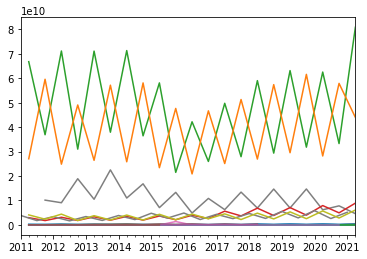

In [12]:
fig, ax = plt.subplots()

for workbook in workbooks_combined:
    if 'Operating Revenue' in workbooks_combined[workbook]['Profit Loss']:
        workbooks_combined[workbook]['Profit Loss']['Operating Revenue'].plot()


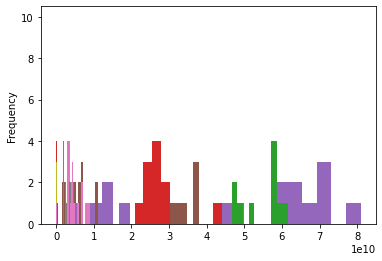

In [13]:
fig, ax = plt.subplots()

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
         if 'Operating Revenue' in workbooks_separated[workbook][period]['Profit Loss']:
                workbooks_separated[workbook][period]['Profit Loss']['Operating Revenue'].plot.hist()
   


[Text(0, 0, '12/01/15'),
 Text(1, 0, '12/01/16'),
 Text(2, 0, '12/01/17'),
 Text(3, 0, '12/01/18'),
 Text(4, 0, '12/01/19'),
 Text(5, 0, '12/01/20')]

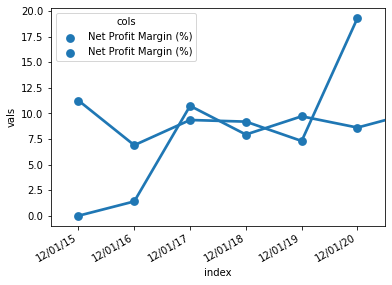

In [14]:
fig, ax = plt.subplots()

test = workbooks_separated['ADH']['FY']['Ratio Analysis'].reset_index().melt('index', var_name='cols',  value_name='vals')
test = test[test['cols'] == 'Net Profit Margin (%)']
test['index'] = test['index'].dt.strftime("%m/%d/%y")

test2 = workbooks_separated['ADH']['HY']['Ratio Analysis'].reset_index().melt('index', var_name='cols',  value_name='vals')
test2 = test2[test2['cols'] == 'Net Profit Margin (%)']
test2['index'] = test2['index'].dt.strftime("%m/%d/%y")



g = sns.pointplot(x="index", y="vals", hue='cols', data=test, kind='point', ha='center', ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')

g2 = sns.pointplot(x="index", y="vals", hue='cols', data=test2, kind='point', ha='center', ax=ax)
g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha='right')




## Ratio Analysis

In [61]:
def calc_DSRI(company):
    days_receivables = company['Ratio Analysis']['Days Receivables']
    for row in range(1, len(days_receivables)):
        t1 = days_receivables.iloc[row]
        t0 = days_receivables.iloc[row-1]
        
        if t1 != 0 and t0 != 0:
            print(t1/t0)
        else:
            print('N/A')

In [63]:
calc_DSRI(workbooks_separated['ADH']['HY'])

1.0491996577415115
0.966538702523148
0.06420262490417711
2.780911932045837
0.6007837939083077


In [56]:
def calc_TATA(company):
    for year in company['Profit Loss'].index:
        incs = company['Profit Loss'].loc[year]
        bs = company['Balance Sheet'].loc[year]
        cf = company['Cash Flow'].loc[year]

        res = incs['PreTax Profit'] - cf['Net Operating Cashflows'] - cf['Net Investing Cashflows']
        res = res / bs['Total Assets']
        print(res)

In [65]:
calc_TATA(workbooks_separated['ADH']['FY'])

0.0
-0.07648714413687507
0.14765037978083057
0.0654293884710999
0.0606175606303816
0.0676640954183589
0.02417713451614893
-0.015864368209551404
